In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime  
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import folium
from folium.plugins import HeatMap
from math import floor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix
from sqlalchemy import create_engine
from sqlalchemy import text
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import csv
from shapely.geometry import Point, Polygon
import time
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import dask.dataframe as dd
from sklearn.neighbors import KNeighborsClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
df = pd.read_csv("Final_Weekend_Model_Data_NoWeather_Crime.csv")
df

Unnamed: 0  longitude   latitude  Hour  Day of Week  Cluster  \
0                0 -73.980415  40.738564     0            6      225   
1                1 -73.981323  40.737522     0            6      225   
2                2 -73.980721  40.738167     0            6      225   
3                3 -73.980370  40.738625     0            6      225   
4                4 -73.981277  40.737244     0            6      225   
...            ...        ...        ...   ...          ...      ...   
342508      461323 -73.988777  40.778099     6            5      386   
342509      461324 -73.978294  40.752399     3            6      120   
342510      461335 -73.970558  40.799046     2            5      447   
342511      461336 -73.965858  40.789978     4            5      197   
342512      461337 -73.997772  40.765095    19            6      398   

        total_weekend_trips  Normalized_Score  
0                      35.0          0.367347  
1                      35.0          0.367347  
2                      35.0          0.367347  
3                      35.0          0.367347  
4                      35.0          0.367347  
...                     ...               ...  
342508                  2.0          0.000000  
342509                 22.0          0.142857  
342510                  5.0          0.306122  
342511                  7.0          0.000000  
342512                 23.0          0.142857  

[342513 rows x 8 columns]

In [3]:
df = df.drop(columns=["Unnamed: 0"])
df

longitude   latitude  Hour  Day of Week  Cluster  total_weekend_trips  \
0      -73.980415  40.738564     0            6      225                 35.0   
1      -73.981323  40.737522     0            6      225                 35.0   
2      -73.980721  40.738167     0            6      225                 35.0   
3      -73.980370  40.738625     0            6      225                 35.0   
4      -73.981277  40.737244     0            6      225                 35.0   
...           ...        ...   ...          ...      ...                  ...   
342508 -73.988777  40.778099     6            5      386                  2.0   
342509 -73.978294  40.752399     3            6      120                 22.0   
342510 -73.970558  40.799046     2            5      447                  5.0   
342511 -73.965858  40.789978     4            5      197                  7.0   
342512 -73.997772  40.765095    19            6      398                 23.0   

        Normalized_Score  
0               0.367347  
1               0.367347  
2               0.367347  
3               0.367347  
4               0.367347  
...                  ...  
342508          0.000000  
342509          0.142857  
342510          0.306122  
342511          0.000000  
342512          0.142857  

[342513 rows x 7 columns]

In [4]:
gdf = gpd.read_file('../Borough_Boundaries.geojson')
manhattan_boundary = gdf[gdf['boro_name'] == 'Manhattan']

In [5]:
bounding_box = manhattan_boundary.geometry.bounds

In [6]:
minx = bounding_box.minx.min()
maxx = bounding_box.maxx.max()
miny = bounding_box.miny.min()
maxy = bounding_box.maxy.max()

In [25]:
dx = 25 / 85000  
dy = 25 / 111000  

In [26]:
nx = int(np.ceil((maxx - minx) / dx))
ny = int(np.ceil((maxy - miny) / dy))

In [27]:
polygons = []

In [28]:
polygons = []
for i in range(ny):
    for j in range(nx):
        polygon = Polygon([
            (minx + j*dx, miny + i*dy),
            (minx + (j+1)*dx, miny + i*dy),
            (minx + (j+1)*dx, miny + (i+1)*dy),
            (minx + j*dx, miny + (i+1)*dy)
        ])
        polygons.append(polygon)

In [29]:
grid = gpd.GeoDataFrame({'geometry': polygons})

In [30]:
manhattan_grid = gpd.overlay(grid, manhattan_boundary, how="intersection")

/var/folders/fq/bzr8_90x2fz7g47x1rk7l_tm0000gn/T/ipykernel_28683/4240997437.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  manhattan_grid = gpd.overlay(grid, manhattan_boundary, how="intersection")


In [31]:
manhattan_grid['longitude'] = manhattan_grid.centroid.x
manhattan_grid['latitude'] = manhattan_grid.centroid.y

In [32]:
print(manhattan_grid[['longitude', 'latitude']])

       longitude   latitude
0     -74.023083  40.683022
1     -74.022953  40.683077
2     -74.023031  40.683149
3     -74.022845  40.683237
4     -74.022675  40.683317
...          ...        ...
97953 -73.910817  40.878946
97954 -73.910523  40.878949
97955 -73.910244  40.878936
97956 -73.909980  40.878895
97957 -73.909783  40.878864

[97958 rows x 2 columns]


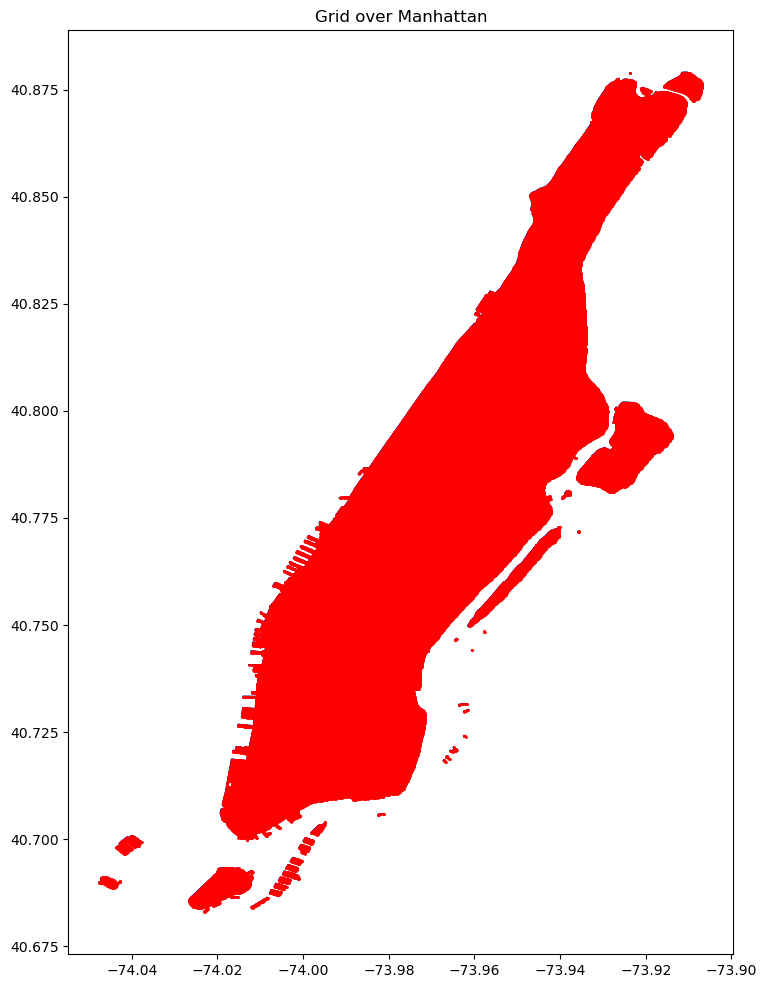

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))
manhattan_boundary.plot(ax=ax, color='whitesmoke', edgecolor='black')

manhattan_grid.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.4)

manhattan_grid.centroid.plot(ax=ax, color='red', markersize=1)

ax.set_title("Grid over Manhattan")
plt.show()

***

## Interactive map containing grid centroids

In [60]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=13)

subset = manhattan_grid.sample(n=10000)

In [61]:
for idx, row in subset.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
        fill=True,
        fill_opacity=0.7,
        color="blue"
    ).add_to(m)

In [62]:
m

In [63]:
manhattan_grid

boro_code  boro_name     shape_area    shape_leng  \
0             1  Manhattan  636520502.801  357713.30866   
1             1  Manhattan  636520502.801  357713.30866   
2             1  Manhattan  636520502.801  357713.30866   
3             1  Manhattan  636520502.801  357713.30866   
4             1  Manhattan  636520502.801  357713.30866   
...         ...        ...            ...           ...   
97953         1  Manhattan  636520502.801  357713.30866   
97954         1  Manhattan  636520502.801  357713.30866   
97955         1  Manhattan  636520502.801  357713.30866   
97956         1  Manhattan  636520502.801  357713.30866   
97957         1  Manhattan  636520502.801  357713.30866   

                                                geometry  longitude   latitude  
0      POLYGON ((-74.02302 40.68314, -74.02302 40.682... -74.023083  40.683022  
1      POLYGON ((-74.02302 40.68314, -74.02281 40.683... -74.022953  40.683077  
2      POLYGON ((-74.02302 40.68314, -74.02304 40.683... -74.023031  40.683149  
3      POLYGON ((-74.02302 40.68314, -74.02302 40.683... -74.022845  40.683237  
4      POLYGON ((-74.02273 40.68337, -74.02257 40.683... -74.022675  40.683317  
...                                                  ...        ...        ...  
97953  POLYGON ((-73.91067 40.87886, -73.91096 40.878... -73.910817  40.878946  
97954  POLYGON ((-73.91038 40.87886, -73.91067 40.878... -73.910523  40.878949  
97955  POLYGON ((-73.91008 40.87886, -73.91038 40.878... -73.910244  40.878936  
97956  POLYGON ((-73.90979 40.87886, -73.91008 40.878... -73.909980  40.878895  
97957  POLYGON ((-73.90979 40.87886, -73.90979 40.878... -73.909783  40.878864  

[97958 rows x 7 columns]

In [64]:
df1 = manhattan_grid[["longitude","latitude"]]

In [65]:
df1

longitude   latitude
0     -74.023083  40.683022
1     -74.022953  40.683077
2     -74.023031  40.683149
3     -74.022845  40.683237
4     -74.022675  40.683317
...          ...        ...
97953 -73.910817  40.878946
97954 -73.910523  40.878949
97955 -73.910244  40.878936
97956 -73.909980  40.878895
97957 -73.909783  40.878864

[97958 rows x 2 columns]

In [67]:
df1.to_csv("manhattan_grids_lat_long.csv")